# Loading Modules

In [3]:
from display import Display, minmax, place_object
from main import init
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from what import WhatShift, WhatBackground, WhatNet, WhatTrainer, What, train, test, MNIST

# Loading the Data

- Loading the data with the parameters given in the .json file

In [4]:
args = init(filename='2020-07-01')
dis = Display(args)
data, label = next(iter(dis.loader_test))

In [5]:
args

{'w': 28,
 'minibatch_size': 100,
 'train_batch_size': 50000,
 'test_batch_size': 10000,
 'noise_batch_size': 1000,
 'mean': 0.1307,
 'std': 0.3081,
 'what_offset_std': 15,
 'what_offset_max': 25,
 'N_pic': 128,
 'offset_std': 30,
 'offset_max': 34,
 'noise': 0.75,
 'contrast': 0.7,
 'sf_0': 0.1,
 'B_sf': 0.1,
 'do_mask': True,
 'N_theta': 6,
 'N_azimuth': 24,
 'N_eccentricity': 10,
 'N_phase': 2,
 'rho': 1.41,
 'bias_deconv': True,
 'p_dropout': 0.0,
 'dim1': 1000,
 'dim2': 1000,
 'lr': 0.005,
 'do_adam': True,
 'bn1_bn_momentum': 0.5,
 'bn2_bn_momentum': 0.5,
 'momentum': 0.3,
 'epochs': 60,
 'num_processes': 1,
 'no_cuda': False,
 'log_interval': 100,
 'verbose': 1,
 'filename': '2020-07-01',
 'seed': 2019,
 'N_cv': 10,
 'do_compute': True,
 'save_model': True}

- Checking the tensor size

- Visualizing the first 8 digits

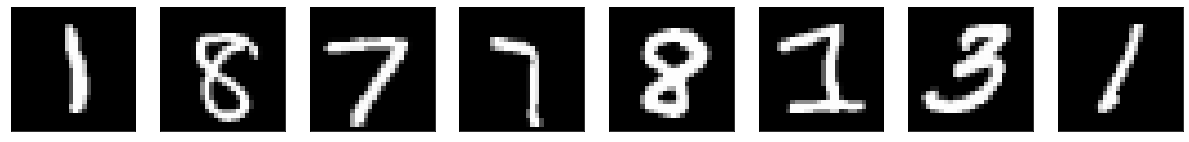

In [3]:
N_plot = 8
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    ax.imshow(data[i_ax, 0, :, :], cmap=plt.gray())
    ax.set_xticks([])
    ax.set_yticks([])

- With noise:

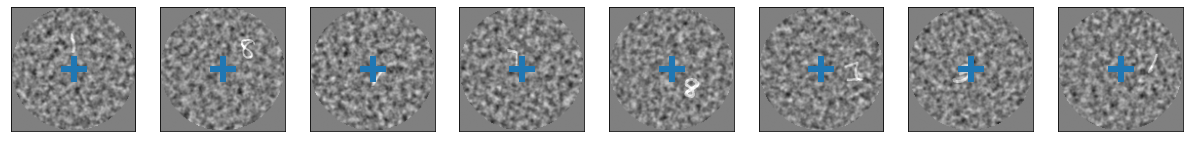

In [4]:
fig, axs = plt.subplots(1, N_plot, figsize = (21, 5))
for i_ax, ax in enumerate(axs):
    data_fullfield, i_offset, j_offset = dis.draw(data[i_ax, 0, :, :].numpy())
    dis.show(ax, data_fullfield)

In [5]:
transform=transforms.Compose([
                               WhatShift(args,i_offset=None, j_offset=None),
                               WhatBackground(contrast = args.contrast,
                                              noise=args.noise, 
                                              sf_0=args.sf_0, 
                                              B_sf=args.B_sf),
                               transforms.ToTensor(),
                               #transforms.Normalize((args.mean,), (args.std,))
                           ])

dataset_train = MNIST('../data',
                        train=True,
                        download=True,
                        transform=transform,
                        )

train_loader = torch.utils.data.DataLoader(dataset_train,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

dataset_test = MNIST('../data',
                        train=False,
                        download=True,
                        transform=transform,
                        )

test_loader = torch.utils.data.DataLoader(dataset_test,
                                         batch_size=args.minibatch_size,
                                         shuffle=True)

In [6]:
data, label = next(iter(train_loader))

tensor(6)

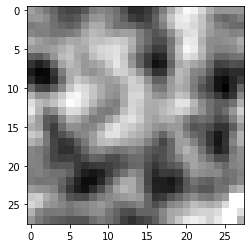

In [8]:
plt.imshow(data[9, :, :].detach().numpy().reshape((28, 28)))
label[9]

# Spatial Transformer Network

In [9]:
def check_cuda() -> torch.device:
    return torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [10]:
device = check_cuda()
device

device(type='cuda')

In [2]:
# Training dataset
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])), batch_size=64, shuffle=True, num_workers=4)
# Test dataset
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST(root='../data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,))
    ])), batch_size=64, shuffle=True, num_workers=4)

In [11]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

        # Spatial transformer localization-network
        self.localization = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=7),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True),
            nn.Conv2d(8, 10, kernel_size=5),
            nn.MaxPool2d(2, stride=2),
            nn.ReLU(True)
        )

        # Regressor for the 3 * 2 affine matrix
        self.fc_loc = nn.Sequential(
            nn.Linear(10 * 3 * 3, 32),
            nn.ReLU(True),
            nn.Linear(32, 3 * 2)
        )

        # Initialize the weights/bias with identity transformation
        self.fc_loc[2].weight.data.zero_()
        self.fc_loc[2].bias.data.copy_(torch.tensor([1, 0, 0, 0, 1, 0], dtype=torch.float))

    # Spatial transformer network forward function
    def stn(self, x):
        xs = self.localization(x)
        xs = xs.view(-1, 10 * 3 * 3)
        theta = self.fc_loc(xs)
        theta = theta.view(-1, 2, 3)

        grid = F.affine_grid(theta, x.size())
        x = F.grid_sample(x, grid)

        return x

    def forward(self, x):
        # transform the input
        x = self.stn(x)

        # Perform the usual forward pass
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net().to(device)

In [12]:
optimizer = optim.SGD(model.parameters(), lr=0.01)


def train(epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

def test():
    with torch.no_grad():
        model.eval()
        test_loss = 0
        correct = 0
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            # sum up batch loss
            test_loss += F.nll_loss(output, target, size_average=False).item()
            # get the index of the max log-probability
            pred = output.max(1, keepdim=True)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()

        test_loss /= len(test_loader.dataset)
        print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'
              .format(test_loss, correct, len(test_loader.dataset),
                      100. * correct / len(test_loader.dataset)))

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.301074
Train Epoch: 1 [50000/60000 (83%)]	Loss: 2.301466

Test set: Average loss: 2.3020, Accuracy: 1028/10000 (10%)

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.298475
Train Epoch: 2 [50000/60000 (83%)]	Loss: 2.303740

Test set: Average loss: 2.3014, Accuracy: 1108/10000 (11%)

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.298866
Train Epoch: 3 [50000/60000 (83%)]	Loss: 2.296095

Test set: Average loss: 2.3012, Accuracy: 1135/10000 (11%)

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.304140
Train Epoch: 4 [50000/60000 (83%)]	Loss: 2.296226

Test set: Average loss: 2.3011, Accuracy: 1135/10000 (11%)

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.307711
Train Epoch: 5 [50000/60000 (83%)]	Loss: 2.300559

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Train Epoch: 6 [0/60000 (0%)]	Loss: 2.297772
Train Epoch: 6 [50000/60000 (83%)]	Loss: 2.298291

Test set: Average loss: 2.3010, Accuracy: 1135/10000 (11%)

Train Epoch: 7 [0/60000 (0%)]	Loss: 2.297516
Train Epoch: 7 [500

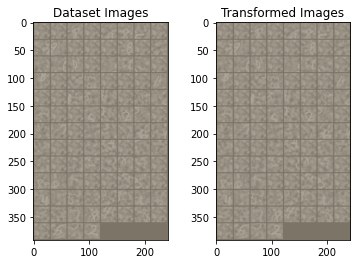

In [13]:
def convert_image_np(inp):
    """Convert a Tensor to numpy image."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    return inp

# We want to visualize the output of the spatial transformers layer
# after the training, we visualize a batch of input images and
# the corresponding transformed batch using STN.


def visualize_stn():
    with torch.no_grad():
        # Get a batch of training data
        data = next(iter(test_loader))[0].to(device)

        input_tensor = data.cpu()
        transformed_input_tensor = model.stn(data).cpu()

        in_grid = convert_image_np(
            torchvision.utils.make_grid(input_tensor))

        out_grid = convert_image_np(
            torchvision.utils.make_grid(transformed_input_tensor))

        # Plot the results side-by-side
        f, axarr = plt.subplots(1, 2)
        axarr[0].imshow(in_grid)
        axarr[0].set_title('Dataset Images')

        axarr[1].imshow(out_grid)
        axarr[1].set_title('Transformed Images')

for epoch in range(1, 20 + 1):
    train(epoch)
    test()

# Visualize the STN transformation on some input batch
visualize_stn()

plt.ioff()
plt.show()

In [15]:
"""import os
from display import get_data_loader
filename_dataset = '../data/noisy-MNIST.pt'

if not os.path.isfile(filename_dataset):
    batch_size = 100
    loader_full = get_data_loader(batch_size=batch_size, train=True, mean=where.args.mean, std=where.args.std, seed=where.args.seed+1)
    im = np.zeros((where.args.train_batch_size, 1, where.args.w, where.args.w))
    im_label = np.zeros(where.args.train_batch_size, dtype = 'int')
    for idx, (data, label) in enumerate (loader_full):
        if idx % 10 == 0:
            print(idx * 100)
        if idx == 500:
            break
        for j in range(batch_size):
            data_fullfield_, i_offset, j_offset = where.display.draw(data[j, 0, :, :].numpy())
            extracted = where.extract(data_fullfield_, i_offset, j_offset)
            im[idx * batch_size + j, 0, :, :] = extracted.reshape(1, 28, 28)
            im_label[idx * batch_size + j] = label[j]
    im = Variable(torch.FloatTensor(im)).to(where.device)
    im_label = Variable(torch.LongTensor(im_label)).to(where.device)
    loader_train = DataLoader(TensorDataset(im, im_label), batch_size=100)
    torch.save(loader_train, filename_dataset)
    """

NameError: name 'where' is not defined